In [28]:
import numpy as np
import matplotlib.pyplot as plt

class IncomeSchedule:
    def __init__(self, initial_monthly_excess, default_annual_growth=0.03, growth_spikes=None):
        """
        initial_monthly_excess: Starting excess cash flow (Income - Expenses).
        default_annual_growth: The baseline raise (e.g., COLA/Inflation).
        growth_spikes: Dict of {year: percent_growth} for promotion years. 
                       e.g., {2: 0.15} means a 15% raise at year 2.
        """
        self.initial = initial_monthly_excess
        self.default_growth = default_annual_growth
        self.spikes = growth_spikes if growth_spikes else {}
        
        # Pre-calculate the monthly income for all 30 years to save time in loops
        self.monthly_values = []
        current = self.initial
        
        for year in range(50): # Calculate up to 50 years just to be safe
            # Determine growth rate for this year
            growth = self.spikes.get(year, self.default_growth)
            
            # If it's year 0, we don't grow yet. 
            # If it's year 1, we apply the growth from year 0 to 1.
            if year > 0:
                current *= (1 + growth)
                
            # Append this year's monthly value 12 times
            self.monthly_values.extend([current] * 12)
            
    def get_monthly_excess(self, month_index):
        if month_index < len(self.monthly_values):
            return self.monthly_values[month_index]
        return self.monthly_values[-1] # Fallback

def run_simulation(
    # --- Simulation Settings ---
    num_simulations=500,
    years=30,
    
    # --- Personal Finance (Now uses Object) ---
    initial_savings=200_000,      
    income_schedule=None,         # PASSED OBJECT: Instance of IncomeSchedule
    
    # --- Stock Market Parameters (Monthly) ---
    stock_annual_return_mean=0.08,
    stock_annual_volatility=0.15,
    
    # --- Strategy A: Buying Parameters ---
    home_price=750_000,
    down_payment_percent=0.20,
    loan_rate_annual=0.065,
    property_tax_rate=0.011,      
    home_insurance_annual=1200,
    hoa_monthly=150,
    
    home_appreciation_mean=0.035, 
    home_appreciation_vol=0.05,
    
    # Rental Income (House Hacking)
    num_tenants=0,                
    rent_income_per_tenant=1200,
    rent_inflation_annual=0.03,   # NEW: Tenant rent increases with market
    vacancy_prob_monthly=0.08,    
    
    # Repairs (Stochastic)
    repair_prob_monthly=0.05,     
    repair_cost_log_mean=7.5,     
    repair_cost_log_sigma=1.0,
    repair_inflation_annual=0.03, # NEW: Repairs get more expensive
    
    # --- Strategy B: Renting Parameters ---
    personal_rent_monthly=3_200,  
    personal_rent_inflation=0.03
):
    
    months = years * 12
    dt = 1/12
    
    # Default income schedule if None passed
    if income_schedule is None:
        income_schedule = IncomeSchedule(4000)

    # Derived Constants
    monthly_rate = loan_rate_annual / 12
    loan_amount = home_price * (1 - down_payment_percent)
    down_payment = home_price * down_payment_percent
    
    # Fixed Mortgage Payment
    if loan_rate_annual > 0:
        mortgage_payment = loan_amount * (monthly_rate * (1 + monthly_rate)**months) / ((1 + monthly_rate)**months - 1)
    else:
        mortgage_payment = loan_amount / months

    # Results Storage
    results = {
        'buy': {'net_worth': np.zeros((num_simulations, months)), 'liquidity': np.zeros((num_simulations, months))},
        'rent': {'net_worth': np.zeros((num_simulations, months)), 'liquidity': np.zeros((num_simulations, months))}
    }

    for sim in range(num_simulations):
        
        # --- Pre-calculate Stochastic Factors ---
        stock_drift = (stock_annual_return_mean - 0.5 * stock_annual_volatility**2) * dt
        stock_shock = stock_annual_volatility * np.sqrt(dt) * np.random.normal(0, 1, months)
        stock_multipliers = np.exp(stock_drift + stock_shock)
        
        home_drift = (home_appreciation_mean - 0.5 * home_appreciation_vol**2) * dt
        home_shock = home_appreciation_vol * np.sqrt(dt) * np.random.normal(0, 1, months)
        home_multipliers = np.exp(home_drift + home_shock)

        is_vacant = np.random.random((months, num_tenants)) < vacancy_prob_monthly
        has_repair = np.random.random(months) < repair_prob_monthly
        base_repair_costs = np.random.lognormal(repair_cost_log_mean, repair_cost_log_sigma, months) * has_repair

        # --- STRATEGY 1: BUYING ---
        liquid_cash = initial_savings - down_payment
        current_home_value = home_price
        curr_loan_balance = loan_amount
        
        # Dynamic variables
        current_tenant_rent = rent_income_per_tenant
        current_repair_multiplier = 1.0
        
        buy_nw = []
        buy_liq = []
        
        for t in range(months):
            # 1. Update Dynamic Factors (Annual Inflation)
            if t > 0 and t % 12 == 0:
                current_tenant_rent *= (1 + rent_inflation_annual)
                current_repair_multiplier *= (1 + repair_inflation_annual)

            # 2. Asset Growth
            current_home_value *= home_multipliers[t]
            liquid_cash *= stock_multipliers[t]
            
            # 3. Cash Inflows
            # Get variable excess income for this specific month
            active_income = income_schedule.get_monthly_excess(t)
            
            # Tenant Income
            active_tenants = num_tenants - np.sum(is_vacant[t])
            rental_income = active_tenants * current_tenant_rent
            
            total_inflow = active_income + rental_income
            
            # 4. Cash Outflows
            monthly_tax = (current_home_value * property_tax_rate) / 12
            monthly_ins = home_insurance_annual / 12
            actual_repair_cost = base_repair_costs[t] * current_repair_multiplier
            
            housing_costs = mortgage_payment + monthly_tax + monthly_ins + hoa_monthly + actual_repair_cost
            
            # 5. Net Update
            liquid_cash += (total_inflow - housing_costs)
            
            # Mortgage Principal
            interest_payment = curr_loan_balance * monthly_rate
            principal_payment = mortgage_payment - interest_payment
            if curr_loan_balance > 0:
                curr_loan_balance -= principal_payment
                if curr_loan_balance < 0: curr_loan_balance = 0
            
            buy_nw.append(current_home_value + liquid_cash - curr_loan_balance)
            buy_liq.append(liquid_cash)
            
        results['buy']['net_worth'][sim] = buy_nw
        results['buy']['liquidity'][sim] = buy_liq

        # --- STRATEGY 2: RENTING ---
        liquid_cash = initial_savings
        current_personal_rent = personal_rent_monthly
        
        rent_nw = []
        rent_liq = []
        
        for t in range(months):
            # 1. Asset Growth
            liquid_cash *= stock_multipliers[t]
            
            # 2. Rent Inflation
            if t > 0 and t % 12 == 0:
                current_personal_rent *= (1 + personal_rent_inflation)
                
            # 3. Cash Flow
            # Variable Income - Variable Rent
            active_income = income_schedule.get_monthly_excess(t)
            cash_flow = active_income - current_personal_rent
            
            liquid_cash += cash_flow
            
            rent_nw.append(liquid_cash)
            rent_liq.append(liquid_cash)

        results['rent']['net_worth'][sim] = rent_nw
        results['rent']['liquidity'][sim] = rent_liq

    return results

# Re-using your plot function exactly as requested
def plot_results(results, years, log_scale=False, ci=90):
    months_arr = np.arange(years * 12) / 12
    low_ci = (100 - ci) / 2
    high_ci = 100 - low_ci
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
    strategies = [('buy', 'Home Ownership', 'blue'), ('rent', 'Rent + Invest', 'orange')]
    
    for key, label, color in strategies:
        data = results[key]['net_worth']
        mean = np.mean(data, axis=0)
        ci_lower = np.percentile(data, low_ci, axis=0)
        ci_upper = np.percentile(data, high_ci, axis=0)
        ax1.plot(months_arr, mean, label=f"{label} (Mean)", color=color, linewidth=2)
        ax1.plot(months_arr, ci_lower, color=color, linestyle=':', alpha=0.6)
        ax1.plot(months_arr, ci_upper, color=color, linestyle=':', alpha=0.6)
        ax1.fill_between(months_arr, ci_lower, ci_upper, color=color, alpha=0.1)

    ax1.set_title(f'Net Worth Projection ({ci}% CI)')
    ax1.set_ylabel('Value ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    if log_scale: ax1.set_yscale('symlog', linthresh=10000)
    ax1.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

    for key, label, color in strategies:
        data = results[key]['liquidity']
        mean = np.mean(data, axis=0)
        ci_lower = np.percentile(data, low_ci, axis=0)
        ci_upper = np.percentile(data, high_ci, axis=0)
        ax2.plot(months_arr, mean, label=f"{label} (Mean)", color=color, linewidth=2)
        ax2.plot(months_arr, ci_lower, color=color, linestyle=':', alpha=0.6)
        ax2.plot(months_arr, ci_upper, color=color, linestyle=':', alpha=0.6)
        ax2.fill_between(months_arr, ci_lower, ci_upper, color=color, alpha=0.1)

    ax2.set_title('Liquidity (Liquid Assets) Projection')
    ax2.set_ylabel('Liquid Value ($)')
    ax2.axhline(y=0, color='red', linestyle='-', alpha=0.3, label="Insolvency Line")
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    if log_scale: ax2.set_yscale('symlog', linthresh=10000)
    ax2.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

    plt.tight_layout()
    plt.show()

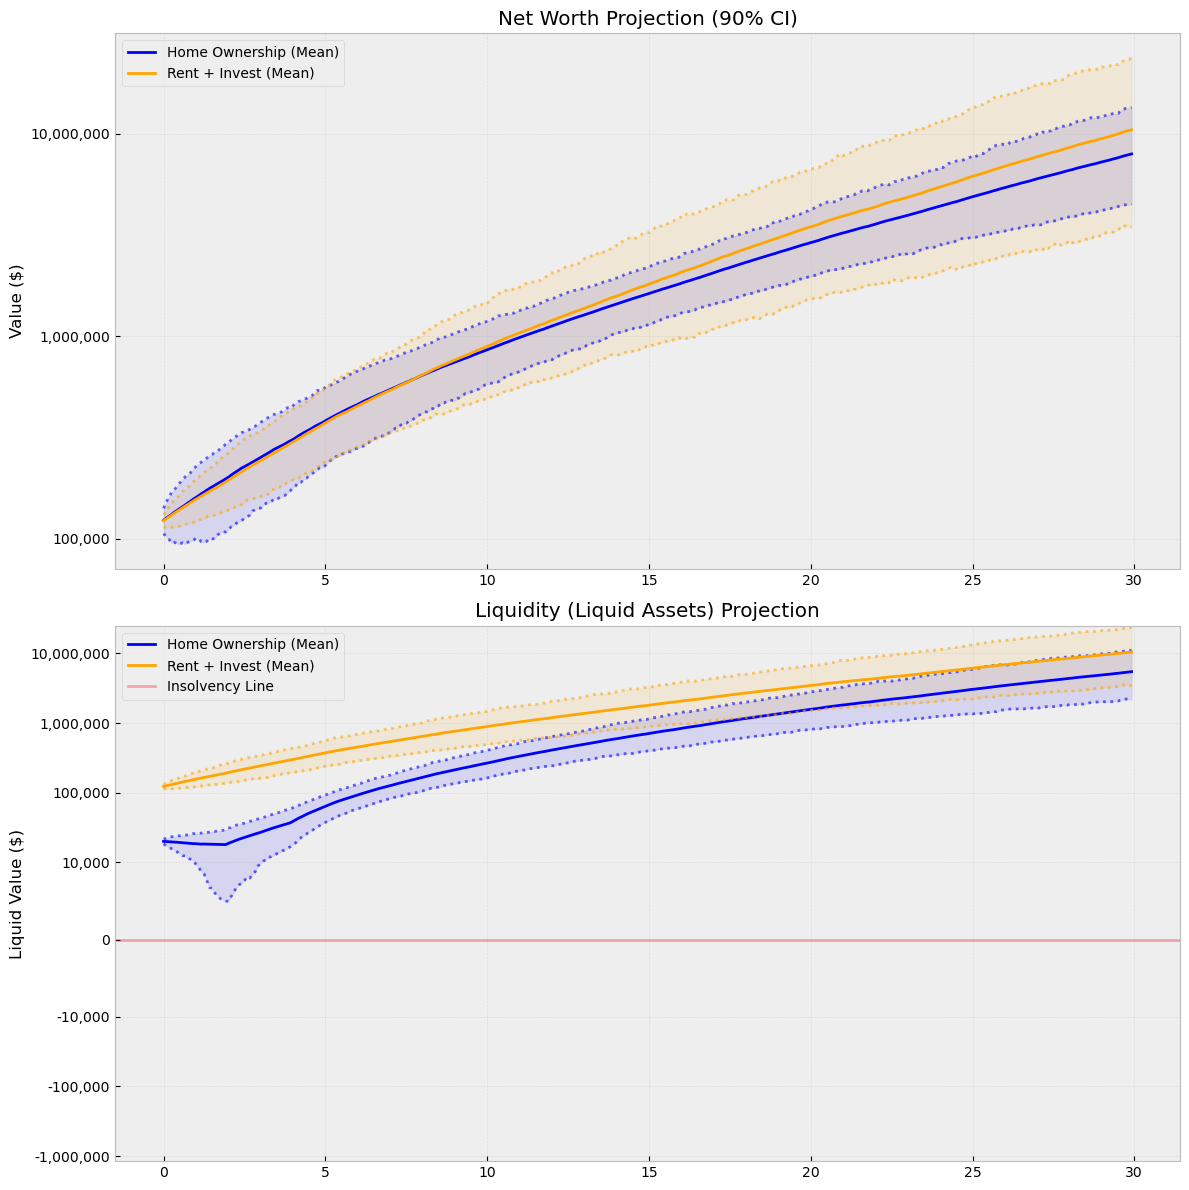

In [ ]:
# --- EXECUTION BLOCK ---
np.random.seed(42)

# 1. Define the Military Income Schedule
# Starting Excess: ~$6400 take home (O-1 NoVA) - $3000 expenses = $3400
mil_income = IncomeSchedule(
    initial_monthly_excess=3_400, 
    default_annual_growth=0.025, # Conservative COLA
    growth_spikes={
        2: 0.20,  # Promotion to O-2 (Year 2)
        4: 0.25,  # Promotion to O-3 (Year 4) - Big jump
        10: 0.15, # Promotion to O-4 (Year 10)
        16: 0.10, # Promotion to O-5 (Year 16)
    }
)

# 2. Define Parameters
home_val = 750_000
down_payment_amt = 100_000
total_assets = 120_000 
dp_percent = down_payment_amt / home_val 
vacancy_prob = 1.0 - 0.95 
years=30

# 3. Run Simulation
results = run_simulation(
    num_simulations=1000,
    years=years,
    
    # Pass the Object
    income_schedule=mil_income, 
    initial_savings=total_assets,
    
    # Market
    stock_annual_return_mean=0.10,
    
    # Buy Params
    home_price=home_val,
    down_payment_percent=dp_percent,
    loan_rate_annual=0.056,
    home_appreciation_mean=0.04,
    
    # Renting Out (House Hacking)
    num_tenants=1,
    rent_income_per_tenant=1200, # Initial rent
    rent_inflation_annual=0.03,   # Rent increases 3% per year
    vacancy_prob_monthly=vacancy_prob,
    
    # Personal Rent (Alternative Strategy)
    personal_rent_monthly=1_800,
    personal_rent_inflation=0.03
)

# 4. Plot
plot_results(results, years, log_scale=True, ci=90)